In [1]:
library(BiodiversityR)
library(tidyverse)

Loading required package: tcltk

Loading required package: vegan

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-6.1

BiodiversityR 2.16-1: Use command BiodiversityRGUI() to launch the Graphical User Interface; 
to see changes use BiodiversityRGUI(changeLog=TRUE, backward.compatibility.messages=TRUE)


── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr:

In [2]:
cost_benefit <- read.csv("Carbon_cost_benefit.csv") |>
                tidyr::drop_na() |>
                dplyr::mutate(Ref = glue::glue("{Date}_{Site}_{Meadow}_{Core}")) |>
                dplyr::filter(Date == "November")

In [3]:
carbon_stock <- cost_benefit |>
                dplyr::select(Carbon_stock_per_core, Ref)

In [4]:
head(cost_benefit)

,X,Date,Site,Meadow,Core,Total_carbon_per_core,Carbon_stock_per_core,Ref
,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<glue>
1,21,November,Bottleray,Bare,1,0.04152924,4.152924,November_Bottleray_Bare_1
2,22,November,Bottleray,Bare,2,0.03480773,3.480773,November_Bottleray_Bare_2
3,23,November,Bottleray,Bare,3,0.03506669,3.506669,November_Bottleray_Bare_3
4,24,November,Bottleray,Bare,4,0.03984852,3.984852,November_Bottleray_Bare_4
5,25,November,Bottleray,Bare,5,0.07299320,7.299320,November_Bottleray_Bare_5
6,26,November,Bottleray,Seagrass,1,0.03725628,3.725628,November_Bottleray_Seagrass_1


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


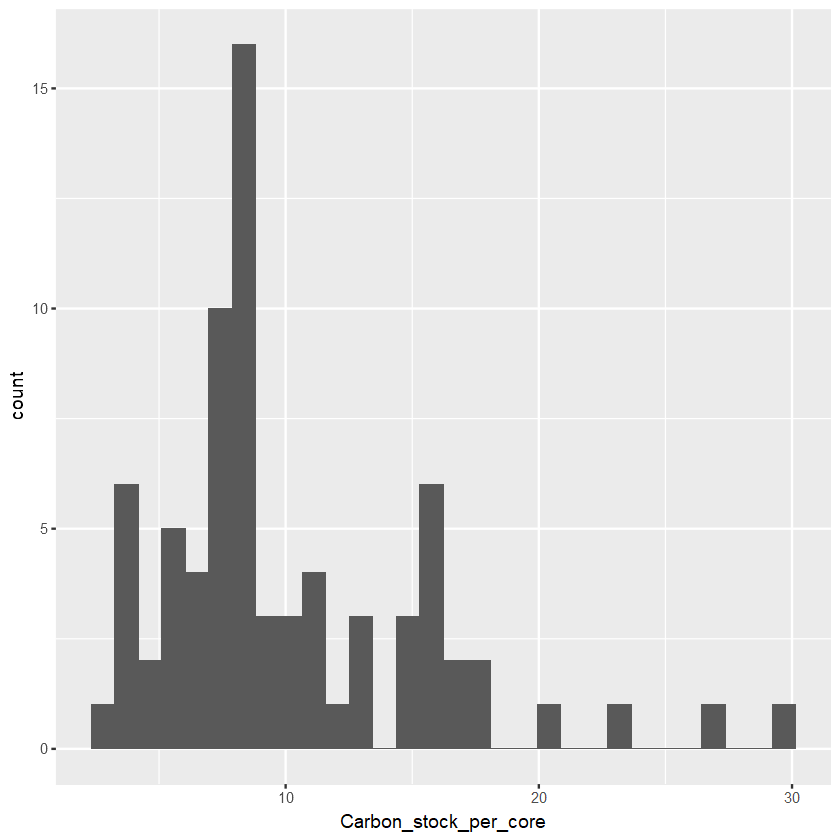

In [5]:
ggplot(carbon_stock, aes(x = Carbon_stock_per_core)) + geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


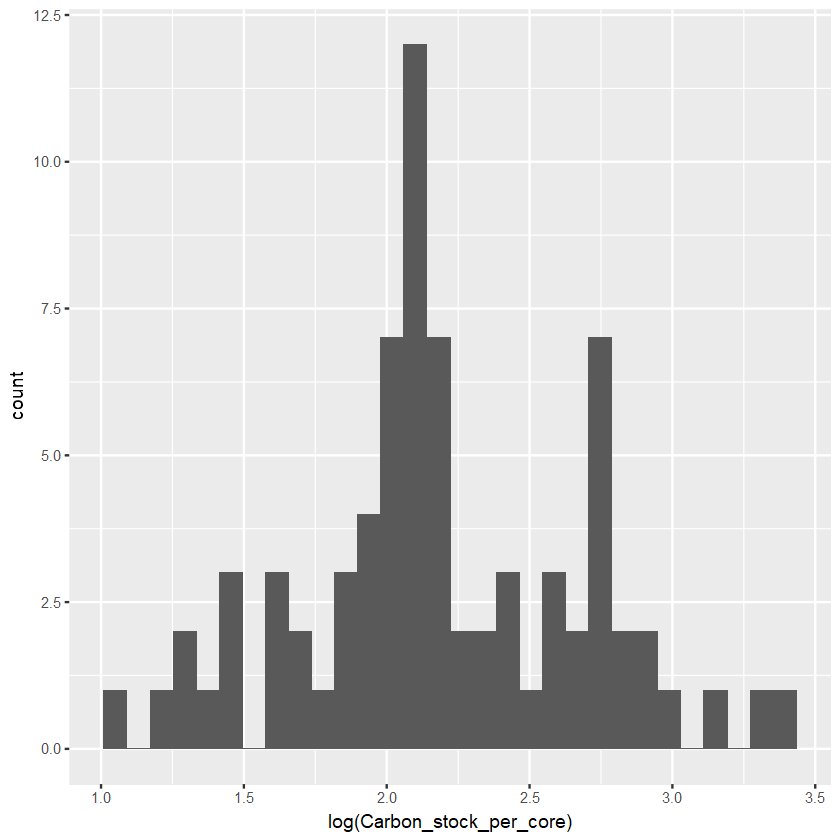

In [6]:
#log transformation makes the data roughly normal
#something to keep in mind as I have not looked into the assumptions
ggplot(carbon_stock, aes(x = log(Carbon_stock_per_core))) + geom_histogram()

In [7]:
(mux <- mean(carbon_stock$Carbon_stock_per_core))
(sdx <- sd(carbon_stock$Carbon_stock_per_core))
(confidence_level <- 0.95)
(q =  1 - (1 - confidence_level)/ 2)
(Z <- qnorm(q, mean = mux, sd =sdx))
# The coefficient of variation for the full dataset
(COV = sdx/mux*100)

[1] 10.0693

[1] 5.288891

[1] 0.95

[1] 0.975

[1] 20.43534

[1] 52.52492

In [8]:
#function for the coefficient of variation 
#Can replace with any other measure 
cumulative_COV <- function(data, var){
    
    lapply(1:nrow(data), function(i){

 
        mean <- mean(data[1:i, var])
        sd <- sd(data[1:i, var])
        my_stat  <- (sd/mean) * 100
        
    return(ifelse(is.na(my_stat), 0, my_stat))
        
    })
}

In [9]:
n_bootstrap = 1000

permutations_list <- lapply(1:n_bootstrap, function(x) {
         N = nrow(carbon_stock)
         sample <- carbon_stock[sample(1:N, size = N, replace = TRUE),] 
         #coefficient of variation
         cumulative_cov = as.numeric(cumulative_COV(sample, "Carbon_stock_per_core"))
         df <- data.frame(cumulative_cov, samples = 1:N )
  df
})

permutations <- do.call(rbind, permutations_list) |>
                data.frame() |>
                tibble::remove_rownames()

In [10]:
head(permutations)

,cumulative_cov,samples
,<dbl>,<int>
1,0.00000,1
2,38.60165,2
3,61.71500,3
4,54.18482,4
5,64.46352,5
6,57.16112,6


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


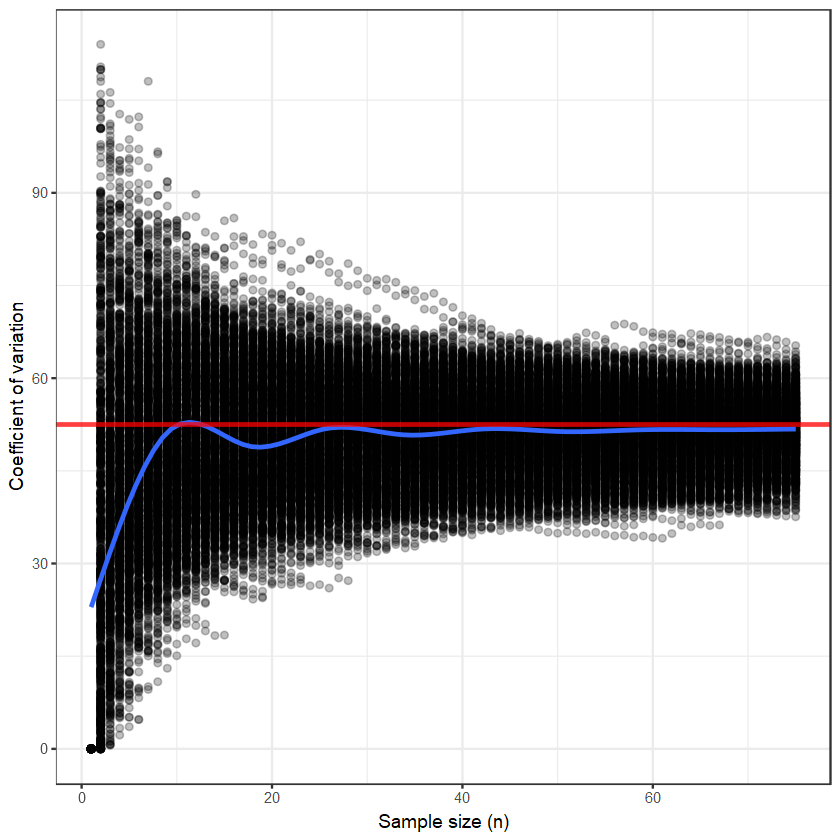

In [11]:
ggplot(permutations, aes(x = samples, y = cumulative_cov)) +
  labs(x = "Sample size (n)", y = "Coefficient of variation") +
  geom_point(alpha = 0.25) +
  geom_smooth() +
  geom_hline(yintercept = COV, color = "red", size=1, alpha = 0.75) +
  theme_bw()

`geom_smooth()` using formula = 'y ~ x'


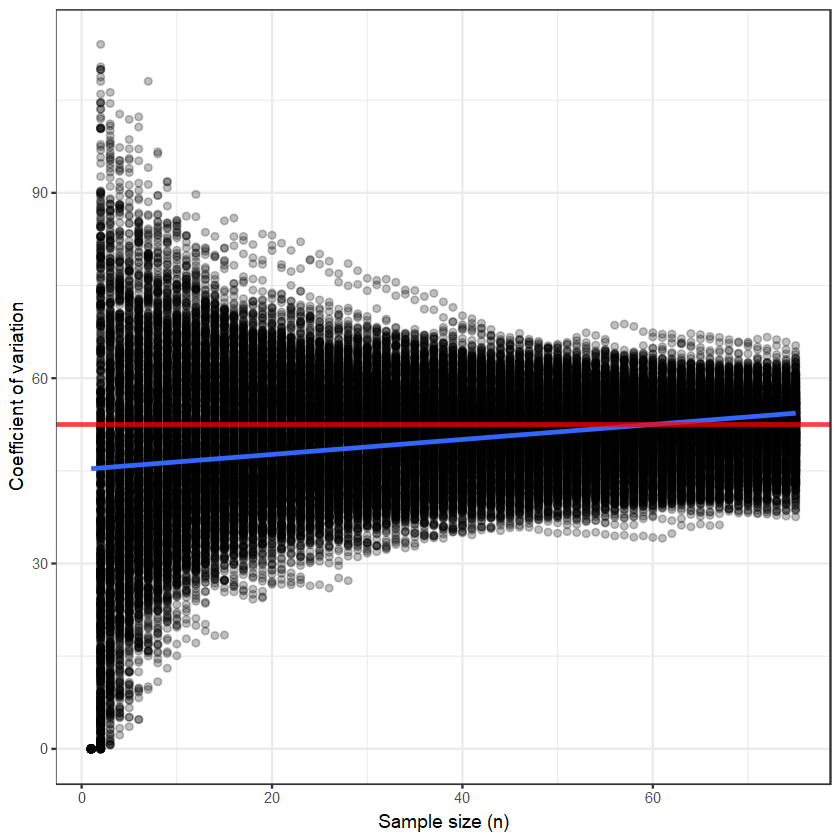

In [12]:
#use linear regression with log transformation
ggplot(permutations, aes(x = samples, y = cumulative_cov)) +
  labs(x = "Sample size (n)", y = "Coefficient of variation") +
  geom_point(alpha = 0.25) +
  geom_smooth(method = "lm") +
  geom_hline(yintercept = COV, color = "red", size=1, alpha = 0.75) +
  theme_bw()

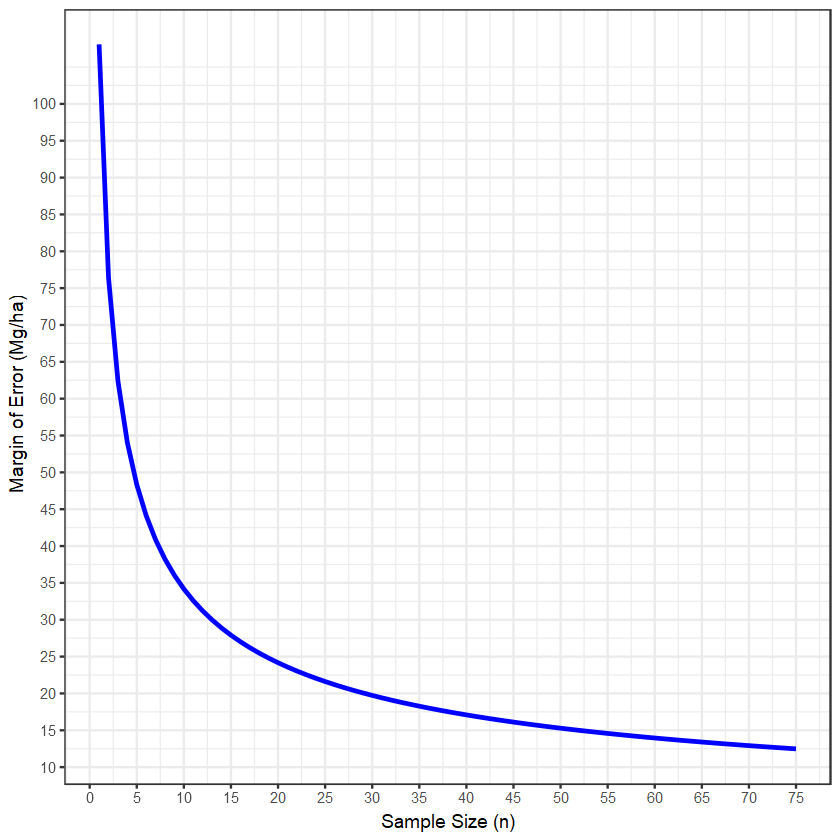

In [13]:
#Can also use margin of error analysis 
#I assume the data follows a normal distribution, can 
sample_sizes <- seq(1:nrow(carbon_stock))
margin_of_error <- Z * (sdx / sqrt(sample_sizes))
MOE_data <- data.frame(sample_sizes, margin_of_error)  # Create a data frame

ggplot(MOE_data, aes(x = sample_sizes, y = margin_of_error)) +
  geom_line(color = "blue", size = 1) +  
  labs(x = "Sample Size (n)", y = "Margin of Error (Mg/ha)") + 
  scale_x_continuous(breaks = seq(0, 75, 5)) +
  scale_y_continuous(breaks = seq(0, 100, 5)) +
  theme_bw()  